In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.3 MB/s eta 0:00:00
Mounted at /content/gdrive


In [14]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

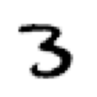

In [4]:
im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3);

In [5]:
im3_t = tensor(im3)
im3_t[0:3,0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [6]:
(im3_t[0:3,0:3] * top_edge).sum()

tensor(0.)

In [7]:
#hide_output
df = pd.DataFrame(im3_t[:10,:20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

In [9]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2,col-1:col+2] * kernel).sum()

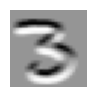

In [11]:
rng = range(1,27)
top_edge3 = tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

show_image(top_edge3);

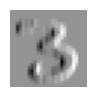

In [12]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

left_edge3 = tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])

show_image(left_edge3);

In [15]:
left_edge = tensor([[-1,1,0],
                    [-1,1,0],
                    [-1,1,0]]).float()

top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [16]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([64, 1, 28, 28])

In [18]:
xb,yb = to_cpu(xb),to_cpu(yb)

In [17]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [19]:
edge_kernels = edge_kernels.unsqueeze(1)

In [20]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

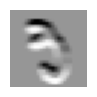

In [27]:
show_image(batch_features[0,1]);

In [28]:
# 创建一个卷积神经网络
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1)
)

In [29]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [30]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

In [31]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [32]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [33]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [34]:
learn.fit_one_cycle(2, 0.01)

In [35]:
# 彩色图像
im = image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

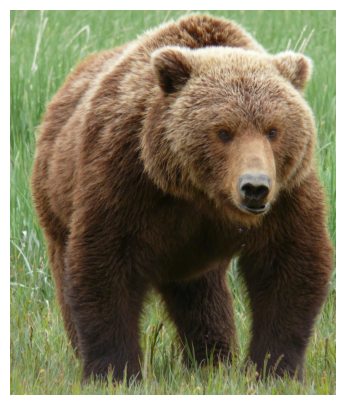

In [36]:
show_image(im);

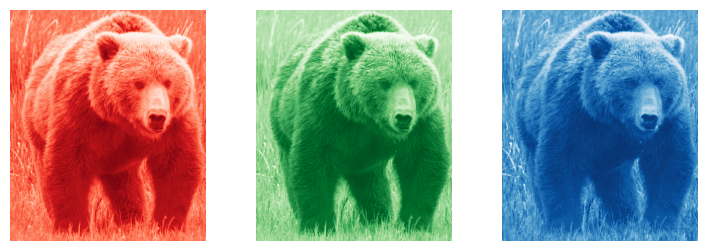

In [37]:
_,axs = subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear, ax=ax, cmap=color)

In [38]:
# 提高训练稳定性
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

In [39]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

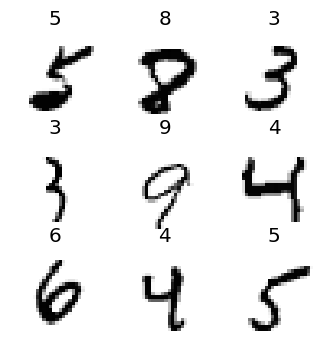

In [42]:
dls.show_batch(max_n=9, figsize=(4,4))

In [51]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

In [52]:
from fastai.callback.hook import *

In [63]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

learn = fit()

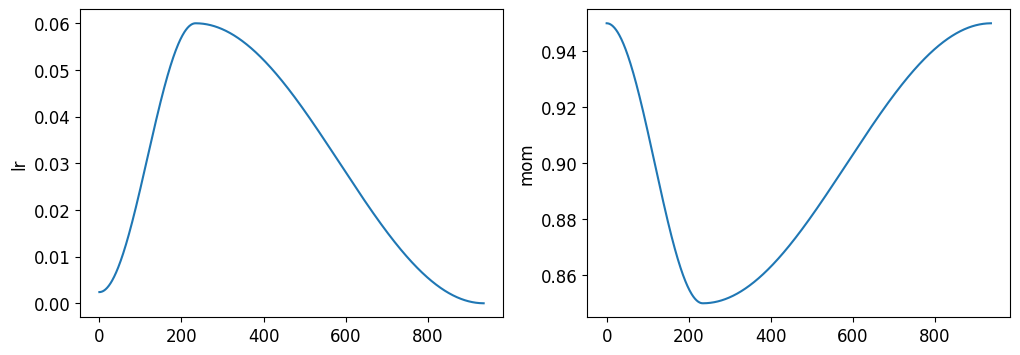

In [64]:
learn.recorder.plot_sched()

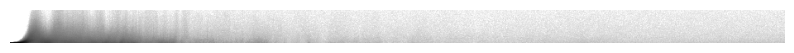

In [70]:
learn.activation_stats.color_dim(-2)

In [71]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [72]:
learn = fit()

/usr/local/lib/python3.10/dist-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


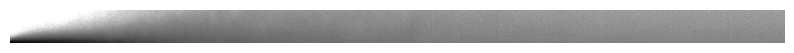

In [75]:
learn.activation_stats.color_dim(-4)

In [76]:
learn = fit(5, lr=0.1)